# Antibiotic Resistance Database using CARD

This notebook is part of the analysis of the TotalRNA mRNA genes from Trinity. 

See more [here](https://www.youtube.com/watch?v=FvOCDlcYaTo&list=PL3izGL6oi0S8RG8vnwLXFznzJnKh8OR8F&index=6).

## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Diamond, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge diamond pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```

### Sanity check

In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
bash --version | head -n 1

diamond version 2.1.8
1.1.5
3.3.4
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

### Input files (edit this chunk)
Edit this chunk to match your input files

In [3]:
trinity_file = '../data/contigs.fasta'
count_table = '../data/mapped_reads_to_contigs.tsv'

In [4]:
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), 'Trinity file does not exist'
assert os.path.exists(count_table), 'Count table does not exist'

### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = '../results/CARD_matches.tsv'

### Database files
Don't edit this chunk

In [6]:
database = "/data_2/Databases/CARD/CARD.dmnd"
annotation_file = "/data_2/Databases/CARD/aro_index.tsv"
assert os.path.exists(annotation_file), 'Annotation file does not exist'
assert os.path.exists(database), 'Database file does not exist'

##### Run Diamond

We will use the same Diamond parameters as in the paper. Please, consider using cutoff in the percentage of identity and the length of the alignment.

In [7]:
%%bash -s "$database" "$trinity_file" "$outfile_matches"
if [ ! -f $3 ]; then
mkdir -p $(dirname $3)
diamond blastx -k 1 -e 1e-4 -p 20 -d $1 -q $2 -o $3 2> /dev/null
fi
head $3

TRINITY_DN2264898_c0_g1_i1	gb|AEJ08681.1|ARO:3001109|SHV-52	100	286	0	0	1	858	1	286	1.73e-202	551


##### Preprocessing diamond matches
We read the file into a pandas table:

In [8]:
diamond = pd.read_csv(
    outfile_matches, delimiter='\t',comment='#', header=None,
    names= ['Query id', 'Subject id', '% identity', 'alignment length', 
             'mismatches','gap openings','q. start', 'q. end',
             's. start', 's. end', 'e-value', 'score'
            ]
)
diamond

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,TRINITY_DN2264898_c0_g1_i1,gb|AEJ08681.1|ARO:3001109|SHV-52,100,286,0,0,1,858,1,286,1.730000e-202,551


We also add the count table into a Pandas data frame:

In [9]:
counts = pd.read_csv(
    count_table, sep = "\t", comment='#'
).set_index('ContigID')
counts

,SampleA,SampleB,SampleC,SampleD,SampleE
ContigID,,,,,
TRINITY_DN226500_c0_g1_i1,0,0,2,1,0
TRINITY_DN226510_c0_g1_i1,1,0,0,0,5
TRINITY_DN226477_c0_g1_i1,0,0,0,0,0
TRINITY_DN226449_c0_g1_i1,0,0,2,0,0
TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
TRINITY_DN226454_c0_g1_i1,0,0,0,9,0
TRINITY_DN226455_c0_g1_i1,0,2,0,0,2
TRINITY_DN2264898_c0_g1_i1,0,2,1,1,2
TRINITY_DN78676876898_c0_g1_i1,0,2,1,1,20


##### Most significant hit per contig
First, we are going to drop unsignificant hits by E-value. We are setting a 0.0001 threshold.


Text(0.5, 1.0, 'E-value distribution before filtering')

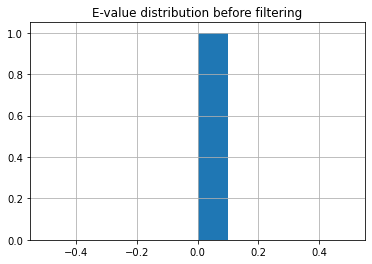

In [10]:
diamond.hist("e-value")
plt.title("E-value distribution before filtering")

Text(0.5, 1.0, 'E-value distribution after filtering (with threshold 0.0001)')

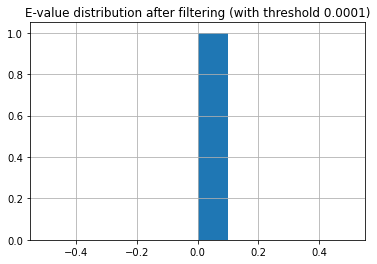

In [11]:
evalue_threshold = 0.0001
diamond = diamond.loc[diamond['e-value'] < evalue_threshold] 
diamond.hist("e-value")
plt.title(f"E-value distribution after filtering (with threshold {evalue_threshold})")


Now, we will sort rows per e-value and score and get the most significant hit per each ContigId.

Text(0.5, 1.0, 'Number of hits per contig before preprocessing')

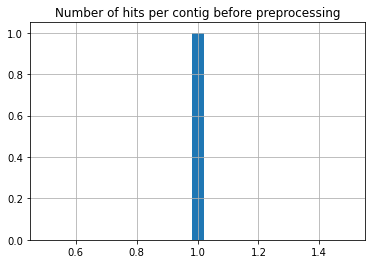

In [12]:
diamond.pivot_table(columns=['Query id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig before preprocessing")


Number of rows. Before: 12. After: 11


Text(0.5, 1.0, 'Number of hits per contig after preprocessing')

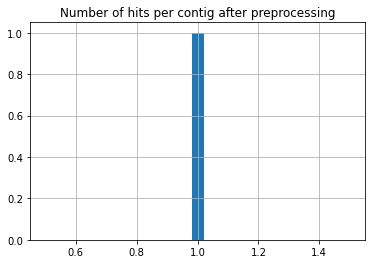

In [13]:
before = diamond.size
diamond = diamond.sort_values(
        by=['e-value', 'score'], ascending=[True, False]
        ).drop_duplicates(
    'Query id', keep='first'
).set_index('Query id')
after = diamond.size

print(f"Number of rows. Before: {before}. After: {after}")

diamond.pivot_table(columns=['Query id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig after preprocessing")

#####  Inspect % identity and aligment length

Text(0.5, 1.0, 'Alignment length distribution after preprocessing')

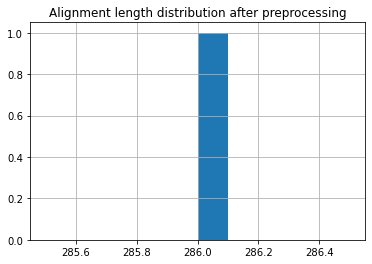

In [14]:
diamond.hist("alignment length")
plt.title("Alignment length distribution after preprocessing")


Text(0, 0.5, 'Mistmatches')

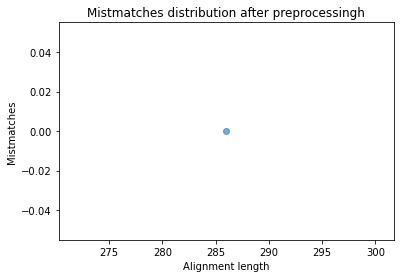

In [15]:
plt.scatter(diamond['alignment length'],diamond.mismatches,alpha=0.6)
plt.title('Mistmatches distribution after preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0.5, 1.0, 'Percentage of identity distribution after preprocessing')

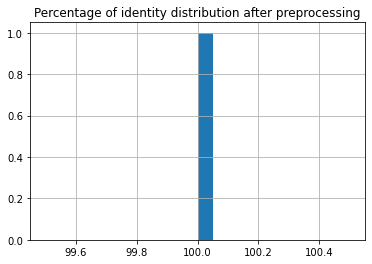

In [16]:
diamond.hist("% identity", bins = 20)
plt.title("Percentage of identity distribution after preprocessing")

Now, consider filtering by identity and alignment length (not strictly necessary).

In [17]:
# Keep only hits with at least 70% identity
#diamond = diamond.loc[diamond['% identity'] >= 70]
# Keep only hits with at least 25 alignment length
#diamond = diamond.loc[diamond['alignment length'] >= 25]
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
TRINITY_DN2264898_c0_g1_i1,gb|AEJ08681.1|ARO:3001109|SHV-52,100,286,0,0,1,858,1,286,1.730000e-202,551


##### Link information form diamond matches and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header

In [18]:
map_table = diamond[["Subject id"]]
map_table

,Subject id
Query id,
TRINITY_DN2264898_c0_g1_i1,gb|AEJ08681.1|ARO:3001109|SHV-52


Now, we will merge both files by their column in common (ContigID and Subject id).

In [19]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(drop=True)
df


,Subject id,SampleA,SampleB,SampleC,SampleD,SampleE
0,gb|AEJ08681.1|ARO:3001109|SHV-52,0,2,1,1,2


##### Aggregate table
Now, we are going to aggregate the rows by grouping them by "Subject id" (notice the difference in rows between the previous table and the following):

In [20]:
df = df.groupby('Subject id').sum(numeric_only = True)
df

,SampleA,SampleB,SampleC,SampleD,SampleE
Subject id,,,,,
gb|AEJ08681.1|ARO:3001109|SHV-52,0,2,1,1,2


# Annotation
First, let read the annotation file into a pandas table:

In [21]:
annotations = pd.read_csv(
    annotation_file, sep="\t", comment="#"
)
# Consider including or excluding information
annotations = annotations.loc[:, ['ARO Accession', 'ARO Name', 'AMR Gene Family', 'Drug Class', 'Resistance Mechanism', 'CARD Short Name']]  # Retorna un nuevo DataFrame con las columnas seleccionadas
annotations

,ARO Accession,ARO Name,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
0,ARO:3005099,23S rRNA (adenine(2058)-N(6))-methyltransferas...,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,Spyo_ErmA_MLSb
1,ARO:3002523,AAC(2')-Ia,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ia
2,ARO:3002524,AAC(2')-Ib,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ib
3,ARO:3002525,AAC(2')-Ic,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ic
4,ARO:3002526,AAC(2')-Id,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Id
...,...,...,...,...,...,...
5173,ARO:3003063,ykkC,small multidrug resistance (SMR) antibiotic ef...,aminoglycoside antibiotic;phenicol antibiotic;...,antibiotic efflux,ykkC
5174,ARO:3003064,ykkD,small multidrug resistance (SMR) antibiotic ef...,aminoglycoside antibiotic;phenicol antibiotic;...,antibiotic efflux,ykkD
5175,ARO:3003952,YojI,ATP-binding cassette (ABC) antibiotic efflux pump,peptide antibiotic,antibiotic efflux,YojI
5176,ARO:3005035,Yrc-1,YRC Beta-lactamase,cephalosporin;cephamycin;penam,antibiotic inactivation,Yrc-1


In [22]:
import doctest
def get_annotation_from_ARO_id(x: str) -> str:
    """
    Extracts the ARO ID from the input string.
    >>> get_annotation_from_ARO_id('gb|AEJ08681.1|ARO:3001109|SHV-52')
    'ARO:3001109'
    """
    parts = x.split('|')
    for part in parts:
        if part.startswith('ARO:'):
            return part
    return ""
# Run tests
doctest.testmod()

TestResults(failed=0, attempted=1)

In [23]:
df['ARO Accession'] = df.index.map(get_annotation_from_ARO_id).to_list()
df = df.groupby('ARO Accession').sum(numeric_only=True)
df

,SampleA,SampleB,SampleC,SampleD,SampleE
ARO Accession,,,,,
ARO:3001109,0,2,1,1,2


Now, we merge both tables by their column in common (Subject id and orthologous genes header)

In [24]:
df = df.merge(
    annotations, left_on='ARO Accession',
    right_on='ARO Accession', how = 'left'
    ).set_index('ARO Accession')
df

,SampleA,SampleB,SampleC,SampleD,SampleE,ARO Name,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
ARO Accession,,,,,,,,,,
ARO:3001109,0,2,1,1,2,SHV-52,SHV beta-lactamase,carbapenem;cephalosporin;penam,antibiotic inactivation,SHV-52


Finally, we save the table and remove the temporary files:

In [25]:
df.to_csv('../results/CARD_matches_annotated.tsv', sep='\t')